# Wildfire mapping using Sentinel-2

In this notebook, we want to show a use case of mapping wildfire using Sentinel-2 following the method discussed in the work of [Nolde et al. (2020)]( https://www.mdpi.com/2072-4292/12/13/2162#). Here, we want to replicate only a part of the workflow. Thus, it involves calculating cloud-free differences in NDVI for pre and post-fire data and comparing them.

In [1]:
import scipy
import numpy as np

import openeo
from openeo.extra.spectral_indices import compute_indices

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show

In [2]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


For this usecase we select an area in Jaen/Spain where fire was noted on 2017/08/03 *(source: https://emergency.copernicus.eu/mapping/list-of-components/EMSR219)*

In [3]:
extent = {"west": -2.6910, "south": 38.2239, "east": -2.5921, "north": 38.3002}

As locations with forest fire often have cloud cover, which hinders the calculation of forest fire-affected areas, we want to get a cloud-free pre-event datacube. Thus, let us define a simple Python function to pre-process pre-event NDVI. Here we use the concept of BAP which means the best available cloud-free pixels right before or right after the forest fire event, this is obtained via cloud masking and temporal reduction with "first" in post event datacube and "last" in pre event datacube.ent date.

Hence:
* We first create a cloud mask with an `SCL` band where we filter out pixels which have a cloud effect;
* Subsequently, a `Gaussian kernel` is created since the cloud masks are frequently noisy and may not completely encompass the cloud region;
* Next, we apply a smoothing function to the selected mask coupled with a morphometric dilation to increase and smooth the mask area. Here, for dilation, we select 11 pixels;
* Following this, a binary mask is produced by applying a threshold of 0.1. This implies that to be classified as cloud-free pixels, the pixels that have undergone smoothing and dilation should exhibit a value below 0.1.
* Once the required `mask` is generated, it is applied to the data cube;
* Finally, once the masked datacube is available, we want to select each cloud-free pixel as near the forest fire date as possible. To achieve this, we reduce the time dimension (`reduce_dimension`) based on the "last" criterion, which selects the nearest cloud-free pixel to the event date.

In [4]:
# define a function to identify cloud-free pixels in the available data-cube


def getBAP(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

## Using Normalized Difference Vegetation Index (NDVI)

### Pre-event NDVI

Let us load Sentinel-2 L2A as our pre-event datacube to calculate NDVI.

In [19]:
# load S2 pre-collection
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2pre_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate ndvi
ndvi_pre = s2pre.ndvi()

In [6]:
# Create a Pre-event cloud free mosiac
ndvi_pre = getBAP(s2pre_scl, ndvi_pre, reducer="last")

In [7]:
ndvi_pre.download("NDVI.tiff")

During the forest fire, we want to know the location of the forest fire as soon as possible. However, it means that the images are often filled with smoke and clouds right after the fire events, which hinders its performance with many cloud-covered pixels where we cannot map the forest fire. 

Therefore, here, we want to show two modes of operation: 

    (i) NRT mode and 
    (ii) Post-event mode. 

In NRT mode, we try to map based on the first available image right after the forest fire event. In post-event mode, we perform pre-processing similar to the pre-event data to obtain cloud-free images. The NRT mode is generally used for the first-response and quick actions, whereas the post mode is used for scientific studies.

### Near Real Time(NRT) Mode NDVI

In [20]:
# load S2 Near-real-time(NRT) collection
s2nrt = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-08-08"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2nrt_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-08-08"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

ndvi_nrt = s2nrt.ndvi()
ndvi_nrt = getBAP(s2nrt_scl, ndvi_nrt, reducer="first")

Now, we have both pre and post event NDVI data we calculate dNDVI (differential NDVI) to find locations where forest fire has occured.

In [9]:
# download NDVI for NRT mode for comparison
ndvi_nrt.download("NRT_NDVI.tiff")

In [10]:
# download signal of fire in near real time
fire_nrt = ndvi_pre - ndvi_nrt
fire_nrt.download("NRT_Fire.tiff")

### Post-event NDVI

In post-event mode, similar to pre-event data, we collect **long-term** image time series and prepare the data to calculate cloud-free NDVI pixels. Notably, here we use the reducer as "first" mainly because this is a post-event time series, and we would like to obtain a cloud-free pixel with NDVI as soon as possible from the forest fire event, therefore selecting the first available cloud-free pixel ensures that we get the earliest cloud-free pixel.

In [21]:
# load S2 post collection
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-11-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2post_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-11-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate post ndvi mosaic
ndvi_post = s2post.ndvi()
ndvi_post = getBAP(s2post_scl, ndvi_post, reducer="first")

In [13]:
# download NDVI for post-event mode for comparison
ndvi_post.download("Post_NDVI.tiff")

In [14]:
fire_mosiac = ndvi_pre - ndvi_post
fire_mosiac.download("Mosiac_Fire.tiff")

### Plot the NDVI

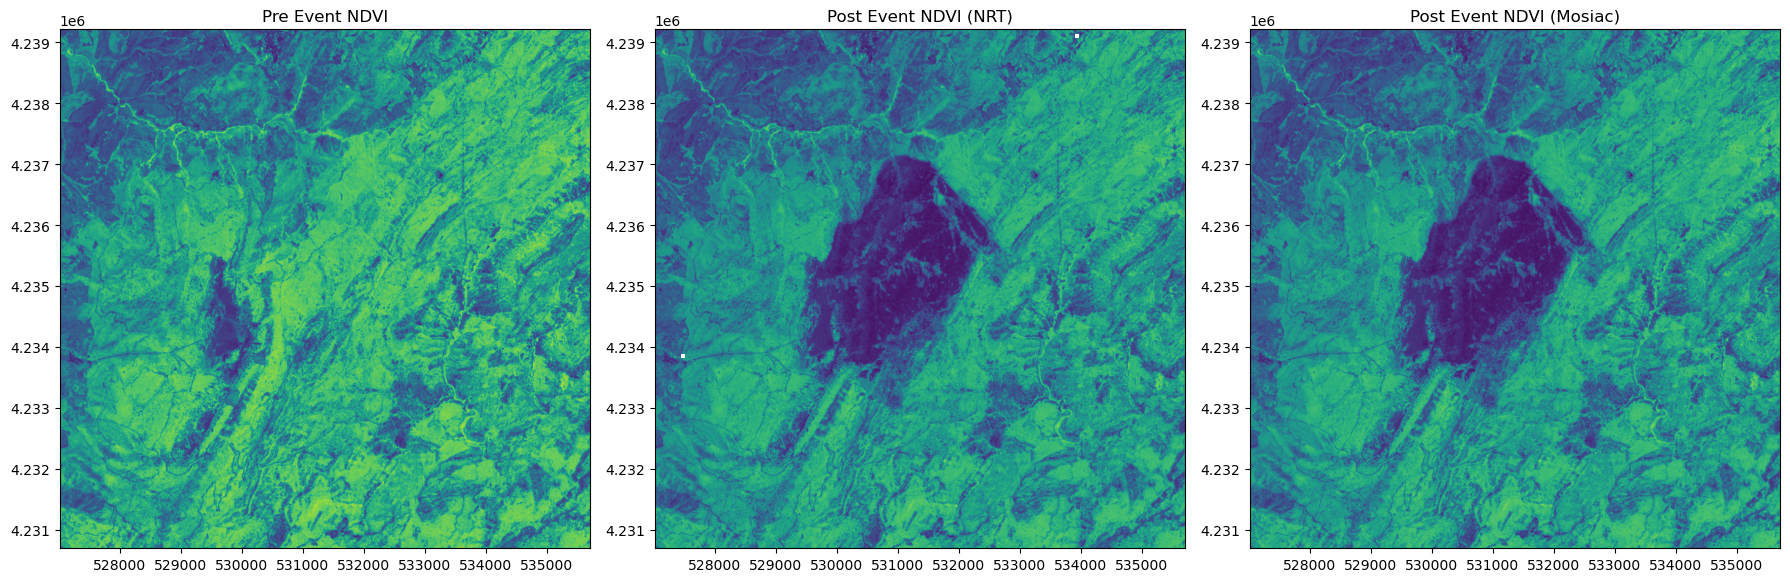

In [15]:
ndvi = rasterio.open("NDVI.tiff")
ndvi_nrt = rasterio.open("NRT_NDVI.tiff")
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(ndvi.read(1), vmin=0, vmax=1, transform=ndvi.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NDVI")

im = show(ndvi_nrt.read(1), vmin=0, vmax=1, transform=ndvi_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NDVI (NRT)")

im = show(
    ndvi_mosiac.read(1), vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NDVI (Mosiac)")
plt.tight_layout()

As we can see there is a drop in NDVI at the locations with forest fire (see end of page for ground truth). This shows that with the adopted approach we can identify locations with forest fire. 

Moreover, we can also observe that in the NDVI NRT mode and NDVI Mosiac mode there is not much difference, the reason could be because the cloud cover was not present in the NRT image. This shows that if there is no cloud cover, both modes operate similarly. Now, based on these image we calculated the difference in NDVI which is the likely locations of forest fire; let's visualize them, too.

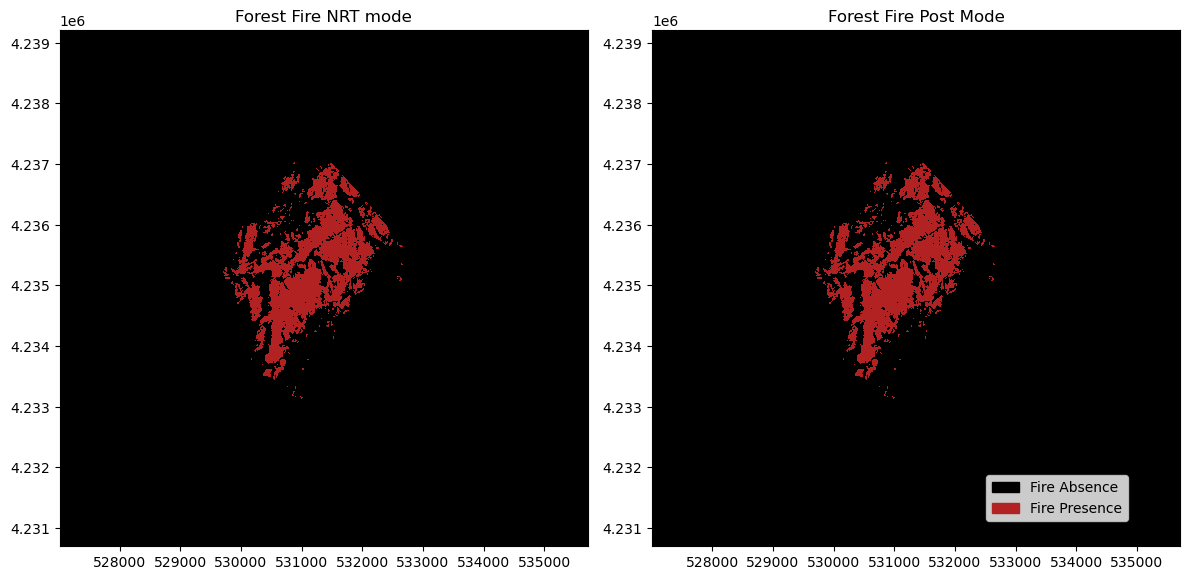

In [16]:
fire_nrt = rasterio.open("NRT_Fire.tiff")
fire_mosiac = rasterio.open("Mosiac_Fire.tiff")

cmap = matplotlib.colors.ListedColormap(["black", "firebrick"])
values = ["Absence", "Presence"]
colors = ["black", "firebrick"]

f, axarr = plt.subplots(1, 2, dpi=100, figsize=(12, 6))

im = show(
    fire_nrt.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_nrt.transform,
    ax=axarr[0],
    cmap=cmap,
)
axarr[0].set_title("Forest Fire NRT mode")

im = show(
    fire_mosiac.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_mosiac.transform,
    ax=axarr[1],
    cmap=cmap,
)
axarr[1].set_title("Forest Fire Post Mode")
patches = [
    mpatches.Patch(color=colors[i], label="Fire {l}".format(l=values[i]))
    for i in range(len(values))
]
f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)
plt.tight_layout()

Here, we can see that the burnt area is quite nicely mapped in both modes and compared to the ground truth image shown at the end of this notebook, the burned area mapping is quite accurate. Moreover, this can still be improved with the NBR data, as suggested by Nolde et al.(2020). Let's try the same with NBR.

## With Normalized Burn Ratio(NBR)

This whole process can also be done with NBR as the [paper](https://www.mdpi.com/2072-4292/12/13/2162#) suggests that NBR produces higher accuracy, but due to the unavailability of SWIR band in medium-resolution satellites, they opted to use NDVI.

*Quoted: "Optionally, the system can utilize the Normalized Burn Ratio (NBR) index ([40], see Equations (3) and (4)) instead of the NDVI. This index features superior capabilities for burnt area discrimination compared to the NDVI"*

Thus, further in this notebook, we also showcase the same process as above with NBR. In this case, all processing steps are the same except for the calculation of NBR instead of NDVI.

In [22]:
nbr_pre = compute_indices(s2pre, indices=["NBR"])
nbr_pre = getBAP(s2pre_scl, nbr_pre, reducer="last")

In [23]:
nbr_pre.download("NBR.tiff")

### NRT mode for NBR

In [25]:
nbr_nrt = compute_indices(s2nrt, indices=["NBR"])
nbr_nrt = getBAP(s2nrt_scl, nbr_nrt, reducer="first")

In [26]:
nbr_nrt.download("NRT_NBR.tiff")

In [27]:
# download signal of fire in near real-time
fire_nrt_nbr = nbr_pre - nbr_nrt
fire_nrt_nbr.download("NRT_NBR_Fire.tiff")

### Post-event mode for NBR

In [29]:
nbr_post = compute_indices(s2post, indices=["NBR"])
nbr_post = getBAP(s2post_scl, nbr_post, reducer="first")

In [30]:
nbr_post.download("Post_NBR.tiff")

In [31]:
fire_nrt_mosiac = nbr_pre - nbr_post
fire_nrt_mosiac.download("Mosiac_NBR_Fire.tiff")

### Plot the NBR

Now we have the NBR and its difference which can be treated as a proxy of forest fire. Let's visualize them, first the NBR alone and then the mapped forest fire from it.

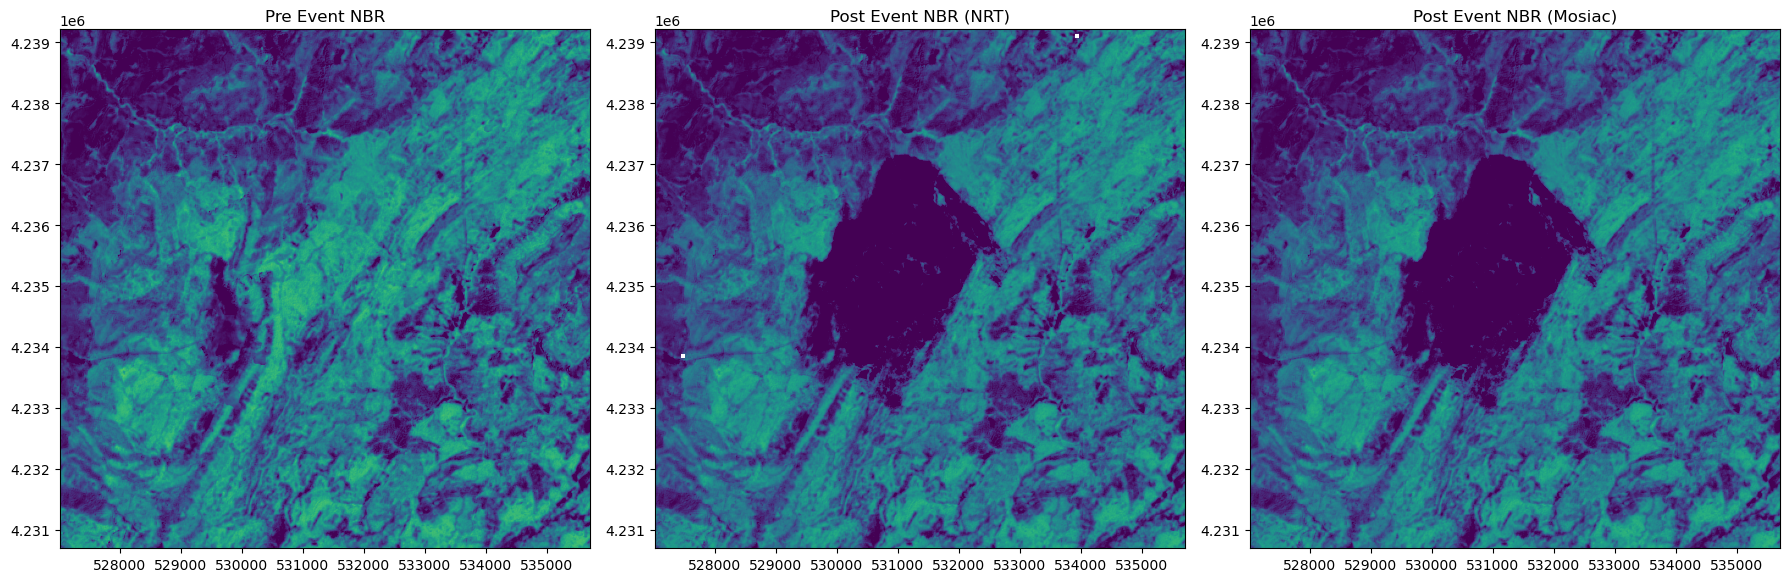

In [34]:
nbr = rasterio.open("NBR.tiff")
nbr_nrt = rasterio.open("NRT_NBR.tiff")
nbr_mosiac = rasterio.open("Post_NBR.tiff")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(nbr.read(1), vmin=0, vmax=1, transform=nbr.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NBR")

im = show(nbr_nrt.read(1), vmin=0, vmax=1, transform=nbr_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NBR (NRT)")

im = show(
    nbr_mosiac.read(1), vmin=0, vmax=1, transform=nbr_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NBR (Mosiac)")
plt.tight_layout()

As we can see, the location of the forest fire is quite prominent in the post-event NBR images compared to that of the pre-event NBR images. This shows that the approach with NBR has better visibility of forest fire signals than the NDVI-based approach. Now, let's see how the final output of the forest fire area looks with the NBR difference image.

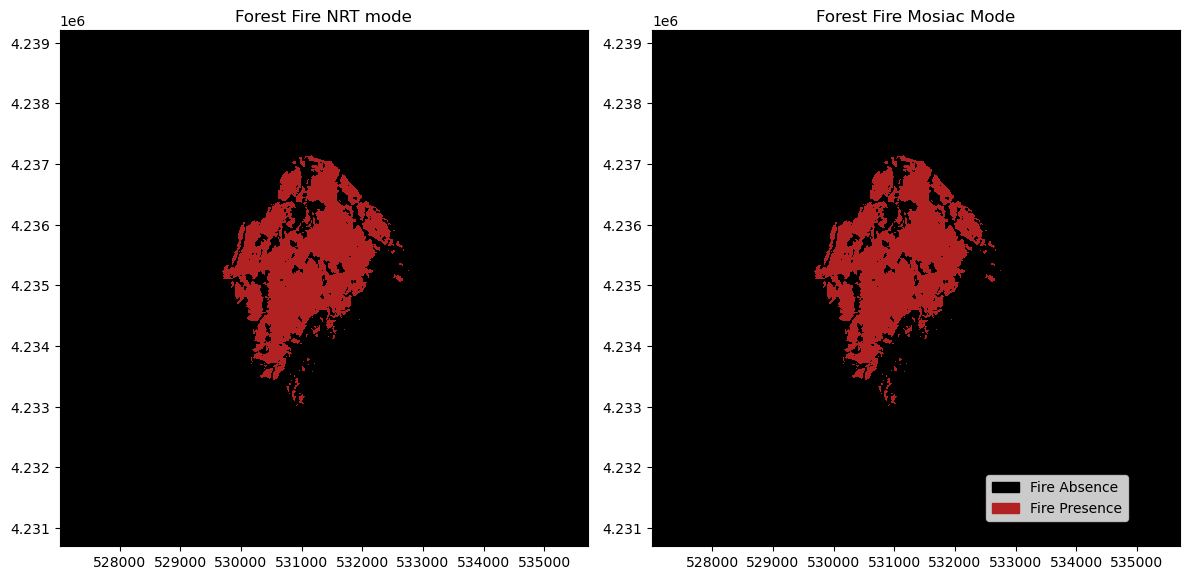

In [35]:
fire_nbr_nrt = rasterio.open("NRT_NBR_Fire.tiff")
fire_nbr_mosiac = rasterio.open("Mosiac_NBR_Fire.tiff")

cmap = matplotlib.colors.ListedColormap(["black", "firebrick"])
values = ["Absence", "Presence"]
colors = ["black", "firebrick"]

f, axarr = plt.subplots(1, 2, dpi=100, figsize=(12, 6))

im = show(
    fire_nbr_nrt.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_nbr_nrt.transform,
    ax=axarr[0],
    cmap=cmap,
)
axarr[0].set_title("Forest Fire NRT mode")

im = show(
    fire_nbr_mosiac.read(1) > 0.5,
    vmin=0,
    vmax=1,
    transform=fire_nbr_mosiac.transform,
    ax=axarr[1],
    cmap=cmap,
)
axarr[1].set_title("Forest Fire Mosiac Mode")
patches = [
    mpatches.Patch(color=colors[i], label="Fire {l}".format(l=values[i]))
    for i in range(len(values))
]
f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)
plt.tight_layout()

We can see here with the use of NBR, the final forest fire area map looks much more complete and less noisy/pixelated compared to the NDVI-based approach. In general, we can see that both NDVI and NBR-based approaches are good for mapping wildfires in near real-time as well as post-event analysis basis. This data can further be used for planning, mitigation and management of forest fire prevention. 

## Ground Truth

As a validation of this workflow, we have a map provided by Copernicus Emergency Management Service (CEMS) is shown below:

<img src="gt.png" alt="Ground Truth" width="1000"/>